# Density Interpolation

It takes a very long time to run the density interpolation functions so I'm afraid a rewrite may be in order. This notebook will be used to:

1. understand how the functions work currently
2. constrain the amount of time it takes to run (scaling up from small samples)
3. rewrite to improve efficiency
4. test to ensure time savings

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [12]:
def func_var_int(ds, variable, rho_grid, dim1='N_PROF', dim2='PRES_INTERPOLATED', flag='group'):
    '''Takes an xarray and density grid, and returns an xarray in density space, with respect to the given variable
    
    ds: xarray in depth space
    variable: variable along which to convert to density
    rho_grid: density grid
    dim1: profiles dimension, default is N_PROF_NEW
    dim2: pressure dimension, default is PRES_INTERPOLATED
    flag: not totally sure
    '''
    
    N_PROF_num = ds[dim1].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho).compute(), drop=True).where(~np.isnan(ds[variable]).compute(), drop=True)
    
    var_nonan = ds[variable].where(~np.isnan(rho).compute(), drop=True).where(~np.isnan(ds[variable]).compute(), drop=True)
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan).compute(), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', dim1],
                        coords = {'rho_grid': rho_grid, dim1: [N_PROF_num]}).rename(variable)

In [13]:
def interpolate2density_prof(ds_z, rho_grid, dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    '''Takes an xarray in depth space and returns an xarray in density space, using the density grid provided.
    
    ds_z: xarray in depth space
    rho_grid: density grid that depth will be interpolated to
    dim1: profiles dimension, default is N_PROF_NEW to make plotting easier down the road
    dim2: pressure dimension, default is PRES_INTERPOLATED
    '''
    
    N_PROF_ind = 0
    PRES_INTERPOLATED_tilde_xr          = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES_INTERPOLATED',rho_grid)
    CT_tilde_xr                         = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT',rho_grid)
    SA_tilde_xr                         = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)
    SIG0_tilde_xr                       = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)
    SPICE_tilde_xr                      = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)
    

    for N_PROF_ind in range(1, len(ds_z.N_PROF)):
        if np.mod(N_PROF_ind, 100)==0:
            print('Completed profile {}'.format(N_PROF_ind))
        PRES_INTERPOLATED_tilde_xr      = xr.concat([PRES_INTERPOLATED_tilde_xr,  func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES_INTERPOLATED', rho_grid)], dim=dim1)
        CT_tilde_xr                     = xr.concat([CT_tilde_xr,    func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT', rho_grid)], dim=dim1)
        SA_tilde_xr                     = xr.concat([SA_tilde_xr,    func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)], dim=dim1)
        SIG0_tilde_xr                   = xr.concat([SIG0_tilde_xr,  func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)], dim=dim1)
        SPICE_tilde_xr                  = xr.concat([SPICE_tilde_xr, func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)], dim=dim1)

    ds_rho = xr.merge([PRES_INTERPOLATED_tilde_xr, CT_tilde_xr,
                             SA_tilde_xr, SIG0_tilde_xr, SPICE_tilde_xr])
    
    ds_rho = ds_rho.assign_coords(TIME      =('N_PROF_NEW',ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =('N_PROF_NEW',ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =('N_PROF_NEW',ds_z.LONGITUDE.data))
    
    return ds_rho

## Small Time Test

In [14]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))

In [15]:
rho_grid = np.arange(21,29,0.0025)

In [16]:
ds_100 = ds.isel(N_PROF=slice(10000,10100))
ds_200 = ds.isel(N_PROF=slice(10000,10200))
ds_500 = ds.isel(N_PROF=slice(10000,10500))
ds_1000 = ds.isel(N_PROF=slice(10000,11000))

In [49]:
%%time
ds_100_rho_norm = interpolate2density_prof(ds_100, rho_grid)

CPU times: user 1min 32s, sys: 4.78 s, total: 1min 36s
Wall time: 1min 32s


/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


In [8]:
print(f'Time to complete all profiles: {(((1*60+30)/100)*2550000)/60/60} hours')

Time to complete all profiles: 637.5 hours


In [36]:
%%time
ds_200_rho = interpolate2density_prof(ds_200, rho_grid)

Completed profile 100
CPU times: user 3min 4s, sys: 11.3 s, total: 3min 16s
Wall time: 3min 7s


In [38]:
print(f'Time to complete all profiles: {(((3*60+7)/200)*2550000)/60/60} hours')

Time to complete all profiles: 662.2916666666666 hours


In [39]:
%%time
ds_500_rho = interpolate2density_prof(ds_500, rho_grid)

Completed profile 100
Completed profile 200
Completed profile 300
Completed profile 400
CPU times: user 7min 52s, sys: 51.1 s, total: 8min 43s
Wall time: 8min 13s


In [40]:
print(f'Time to complete all profiles: {(((8*60+13)/500)*2550000)/60/60} hours')

Time to complete all profiles: 698.4166666666666 hours


In [58]:
%%time
ds_1000_rho_norm = interpolate2density_prof(ds_1000, rho_grid)

Completed profile 100
Completed profile 200
Completed profile 300
Completed profile 400
Completed profile 500
Completed profile 600
Completed profile 700
Completed profile 800
Completed profile 900
CPU times: user 16min 5s, sys: 2min 58s, total: 19min 4s
Wall time: 18min 11s


In [68]:
print(f'Time to complete all profiles: {(((18*60+3)/1000)*2550000)/60/60} hours')

Time to complete all profiles: 767.125 hours


In [17]:
x = [100, 200, 500, 1000]
y_1 = [1*60+30, 3*60+7, 8*60+13, 18*60+3]
y_2 = [637.5, 662.3, 698.4, 767.1]

Text(0, 0.5, 'Time to complete all profiles (hours, extrapolated)')

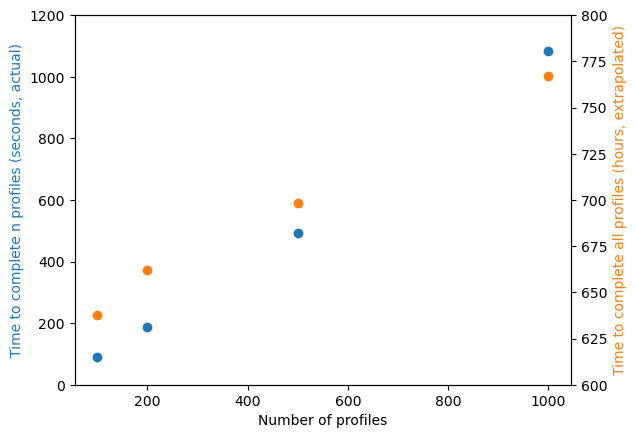

In [18]:
plt.scatter(x, y_1, color='tab:blue')
plt.ylim(0,1200)
plt.ylabel('Time to complete n profiles (seconds, actual)', color='tab:blue')
plt.xlabel('Number of profiles')
plt.twinx()
plt.scatter(x, y_2, color='tab:orange')
plt.ylim(600,800)
plt.ylabel('Time to complete all profiles (hours, extrapolated)', color='tab:orange')

## Rewrite 1: Structural rewrite of `interpolate2density`

In [60]:
def gpt_test(ds_z, rho_grid, dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    '''
    '''
    
    PRES_INTERPOLATED_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'PRES_INTERPOLATED', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    PRES_INTERPOLATED_xr = xr.combine_by_coords(PRES_INTERPOLATED_list)
    print('PRES_INTERPOLATED concat complete')
    
    CT_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'CT', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    CT_xr = xr.combine_by_coords(CT_list)
    print('CT concat complete')
    
    SA_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'SA', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    SA_xr = xr.combine_by_coords(SA_list)
    print('SA concat complete')
    
    SIG0_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'SIG0', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    SIG0_xr = xr.combine_by_coords(SIG0_list)
    print('SIG0 concat complete')
    
    SPICE_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'SPICE', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    SPICE_xr = xr.combine_by_coords(SPICE_list)
    print('SPICE concat complete')

    ds_rho = xr.merge([PRES_INTERPOLATED_xr, CT_xr, SA_xr, SIG0_xr, SPICE_xr])
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [66]:
%%time
ds_100_rho = gpt_test(ds_100, rho_grid)

PRES_INTERPOLATED concat complete
CT concat complete
SA concat complete
SIG0 concat complete
SPICE concat complete
CPU times: user 1min 36s, sys: 4.62 s, total: 1min 40s
Wall time: 1min 35s


In [68]:
print(f'Original function: {1*60+30} seconds')
print(f'gpt_test function: {1*60+35} seconds')

Original function: 90 seconds
gpt_test function: 95 seconds


In [69]:
%%time
ds_200_rho = gpt_test(ds_200, rho_grid)

PRES_INTERPOLATED concat complete
CT concat complete
SA concat complete
SIG0 concat complete
SPICE concat complete
CPU times: user 3min 18s, sys: 11.5 s, total: 3min 30s
Wall time: 3min 18s


In [70]:
print(f'Original function: {3*60+7} seconds')
print(f'gpt_test function: {3*60+18} seconds')

Original function: 187 seconds
gpt_test function: 198 seconds


In [74]:
def gpt_loop(ds_z, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    '''
    '''
    xrs = []
    
    for var in variables:
        var_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), var, rho_grid)
                     for N_PROF in range(len(ds_z[dim1]))]
        var_xr = xr.combine_by_coords(var_list)
        xrs.append(var_xr)
        print(f'{var} concat complete')
    
    ds_rho = xr.merge(xrs)
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [75]:
%%time
ds_100_rho = gpt_loop(ds_100, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE'])

PRES_INTERPOLATED concat complete
CT concat complete
SA concat complete
SIG0 concat complete
SPICE concat complete
CPU times: user 1min 37s, sys: 4.55 s, total: 1min 41s
Wall time: 1min 36s


In [78]:
print(f'Original function: {1*60+30} seconds')
print(f'gpt_test function: {1*60+35} seconds')
print(f'gpt_loop function: {1*60+36} seconds')

Original function: 90 seconds
gpt_test function: 95 seconds
gpt_loop function: 96 seconds


In [ ]:
%%time
ds_200_rho = gpt_loop(ds_200, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE'])

In [79]:
print(f'Original function: {3*60+7} seconds')
print(f'gpt_test function: {3*60+18} seconds')
print(f'gpt_loop function: {3*60+16} seconds')

Original function: 187 seconds
gpt_test function: 198 seconds
gpt_loop function: 196 seconds


I think these functions are more simply written, however they don't lead to any meaningful decrease in computation time. If anything, they are slightly slower than the original function. I think I'm going to turn my focus to the other function now and see if that can produce meaningful time reductions.

In [81]:
def func_var_int(ds, variable, rho_grid, dim1='N_PROF', dim2='PRES_INTERPOLATED', flag='group'):
    ''''''
    
    N_PROF_num = ds[dim1].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[variable].where(~np.isnan(rho), drop=True)
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', dim1],
                        coords = {'rho_grid': rho_grid, dim1: [N_PROF_num]}).rename(variable)

In [ ]:
%%time
ds_100_rho = interpolate2density_prof(ds_100, rho_grid)

## Going to try a systemic rewrite with apply_ufunc

In [50]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [61]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [62]:
%%time
ds_100_rho_new = get_ds_rho(ds_100, ds_100.SIG0, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE']).compute()

Completed comp for PRES_INTERPOLATED
Completed PRES_INTERPOLATED
Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed merge
CPU times: user 721 ms, sys: 451 ms, total: 1.17 s
Wall time: 824 ms


In [55]:
%%time
ds_1000_rho_new = get_ds_rho(ds_1000, ds_1000.SIG0, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE']).compute()

Completed comp for PRES_INTERPOLATED
Completed PRES_INTERPOLATED
Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed merge
CPU times: user 5.95 s, sys: 2.58 s, total: 8.53 s
Wall time: 5.48 s


In [63]:
(5.5/1000)*2550000/60/60

3.8958333333333335

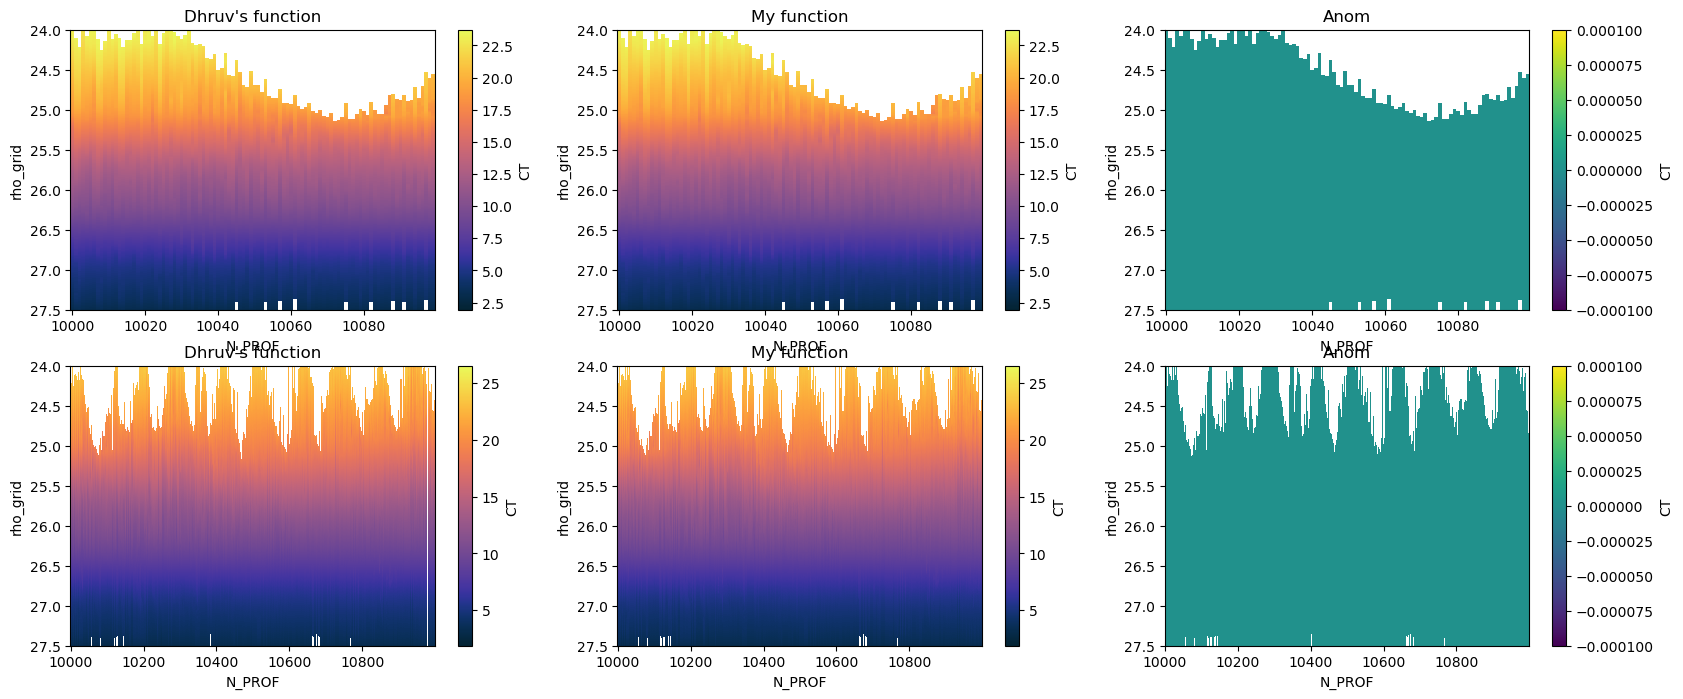

In [59]:
plt.figure(figsize=(20,8))

plt.subplot(231)
ds_100_rho_norm.CT.plot(x='N_PROF', y='rho_grid', cmap=cmo.thermal)
plt.ylim(27.5,24)
plt.title("Dhruv's function")

plt.subplot(232)
ds_100_rho_new.CT.plot(x='N_PROF', y='rho_grid', cmap=cmo.thermal)
plt.ylim(27.5,24)
plt.title("My function")

plt.subplot(233)
(ds_100_rho_norm.CT - ds_100_rho_new.CT).plot(x='N_PROF', y='rho_grid', vmin=-0.0001, vmax=0.0001)
plt.ylim(27.5,24)
plt.title("Anom");

plt.subplot(234)
ds_1000_rho_norm.CT.plot(x='N_PROF', y='rho_grid', cmap=cmo.thermal)
plt.ylim(27.5,24)
plt.title("Dhruv's function")

plt.subplot(235)
ds_1000_rho_new.CT.plot(x='N_PROF', y='rho_grid', cmap=cmo.thermal)
plt.ylim(27.5,24)
plt.title("My function")

plt.subplot(236)
(ds_1000_rho_norm.CT - ds_1000_rho_new.CT).plot(x='N_PROF', y='rho_grid', vmin=-0.0001, vmax=0.0001)
plt.ylim(27.5,24)
plt.title("Anom");

In [6]:
from dask.distributed import Client, LocalCluster

# Set up a LocalCluster with more workers and threads
cluster = LocalCluster(
    n_workers=60,           # number of worker processes (usually = number of cores)
    threads_per_worker=1,  # number of threads per worker
    memory_limit='auto'    # or set like '4GB' per worker
)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 60
Total threads: 60,Total memory: 839.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41817,Workers: 60
Dashboard: http://127.0.0.1:8787/status,Total threads: 60
Started: Just now,Total memory: 839.65 GiB
Comm: tcp://127.0.0.1:45809,Total threads: 1
Dashboard: http://127.0.0.1:46843/status,Memory: 13.99 GiB
Nanny: tcp://127.0.0.1:37547,


2025-06-25 09:57:03,158 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='/swot/SUM05/amf2288/ds_rho.nc', lease_id='0ed7283c5a7c49c892c8e4be929fc7ca'. This can happen if the Lock or Semaphore timed out before.
2025-06-25 10:04:46,844 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='/swot/SUM05/amf2288/ds_rho.nc', lease_id='9987cb89e5b442dd83e8e5c0ab45a1b8'. This can happen if the Lock or Semaphore timed out before.
2025-06-25 10:07:14,315 - distributed.semaphore - WARNING - Tried to release Lock or Semaphore but it was already released: name='/swot/SUM05/amf2288/ds_rho.nc', lease_id='3ce2084ff26845c487f5b6fba9e78411'. This can happen if the Lock or Semaphore timed out before.


In [7]:
%%time
ds_rho = gpt_loop_interp(ds, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE'])

Completed comp for PRES_INTERPOLATED
Completed PRES_INTERPOLATED
Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed merge
CPU times: user 323 ms, sys: 339 ms, total: 662 ms
Wall time: 463 ms


In [9]:
ds_rho.compute()

NameError: name 'ds_rho' is not defined

In [42]:
import dask.array as da

In [38]:
ds_rho = ds_rho.chunk({'N_PROF':100000})
ds_rho = ds_rho.assign_coords({
    'TIME': ds_rho.TIME.chunk({'N_PROF': 100000})})
ds_rho = ds_rho.assign_coords({
    'N_PROF': (('N_PROF',), dask.array.from_array(ds_rho.N_PROF.values, chunks=(100000,))),
    'rho_grid': (('rho_grid',), dask.array.from_array(ds_rho.rho_grid.values, chunks=(3200,)))})

/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 19.46 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [57]:
ds_rho = ds_rho.drop_vars(['rho_grid', 'N_PROF'], errors='ignore')

ds_rho = ds_rho.assign({
    'rho_grid_var': (('rho_grid',), da.from_array(rho_grid, chunks=(3200,))),
    'N_PROF_var': (('N_PROF',), da.from_array(np.arange(ds_rho.dims['N_PROF']), chunks=(100000,)))
})

/tmp/ipykernel_59292/4288862789.py:5: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'N_PROF_var': (('N_PROF',), da.from_array(np.arange(ds_rho.dims['N_PROF']), chunks=(100000,)))


In [58]:
ds_rho

<xarray.Dataset> Size: 327GB
Dimensions:            (N_PROF: 2550896, rho_grid: 3200)
Coordinates:
    TIME               (N_PROF) datetime64[ns] 20MB dask.array<chunksize=(100000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 20MB dask.array<chunksize=(100000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 20MB dask.array<chunksize=(100000,), meta=np.ndarray>
Dimensions without coordinates: N_PROF, rho_grid
Data variables:
    PRES_INTERPOLATED  (N_PROF, rho_grid) int64 65GB dask.array<chunksize=(100000, 3200), meta=np.ndarray>
    CT                 (N_PROF, rho_grid) float64 65GB dask.array<chunksize=(100000, 3200), meta=np.ndarray>
    SA                 (N_PROF, rho_grid) float64 65GB dask.array<chunksize=(100000, 3200), meta=np.ndarray>
    SIG0               (N_PROF, rho_grid) float64 65GB dask.array<chunksize=(100000, 3200), meta=np.ndarray>
    SPICE              (N_PROF, rho_grid) float64 65GB dask.array<chunksize=(100000, 3200), meta=np.ndarray>
    rho_grid_var       (rho_grid) float64 26kB dask.array<chunksize=(3200,), meta=np.ndarray>
    N_PROF_var         (N_PROF) int64 20MB dask.array<chunksize=(100000,), meta=np.ndarray>

In [55]:
for name, var in ds_rho.variables.items():
    if not hasattr(var.data, 'chunks') or var.data.chunks is None:
        print(f"{name} has undefined chunks")

In [56]:
ds_rho.to_zarr('/swot/SUM05/amf2288/ds_rho.zarr', mode='w')

/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/zarr/api/asynchronous.py:213: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 20.81 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result
/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/num

In [ ]:
%%time
ds_rho.load()

In [ ]:
ds_rho